In [ ]:
"""
Description:
    - Import các thư viện cần thiếtthiết
"""
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

## Định nghĩa dataloader

In [2]:
# Ô này tạm thời bỏ qua không quan tâm nhiều
class CMAPSSDataset(Dataset):
    def __init__(self, data, seq_len=30):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.seq_len, :-1]
        target = self.data[idx + self.seq_len - 1, -1]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


In [ ]:
# Trong pytorch, dữ liệu phải được đưa vào một đối tượng mà pytorch có thể tự động đọc, điều này không giống trong keras do cách
# hoạt động khác nhau của mỗi framework
# FD001Dataset sẽ là nơi làm việc này, và trong này cũng miêu tả cách dữ liệu được xử lý như thế nào luôn

"""
Description:
    - Đoạn code trong ô này định nghĩa một dataloader cho pytorch
    - Đối tượng truyền vào là data, sequence_length
    - data chính là dataframe đã được tiền xử lý
    - sequence length là độ dài mà mỗi đầu vào chỉ định cho mô hình Transformer

    - trong hàm khởi tạo __init__, chúng ta chỉ định cách mà loader sẽ xử lý dữ liệu, trong đó:
        * mỗi id sẽ được nhóm thành các nhóm riêng và sau đó
        + lặp qua các nhóm này
        + các cột như ID, Cycle, Remaining RUL sẽ được loại bỏ
        + các cột còn lại sẽ được chuyển đổi thành một mảng numpy
        + mỗi mảng numpy này sẽ được chia thành các mảng con có độ dài sequence_length
        + mỗi mảng con này sẽ được thêm vào một list sequences
        + mỗi mảng con này sẽ được thêm vào một list targets
    - cuối cùng sẽ trả về một list sequences và một list targets ([sequences, targets])
"""
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class FD001Dataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data # Truyền vào data frame đã được xử lý ở trên
        self.sequence_length = sequence_length # Chỉ định khung cho mỗi mẫu data, ta lấy 30 dòng để dự đoán cho dòng 30
        self.sequences = [] # Cứ mỗi lần lấy ra 30 dòng thì thêm nó vào đây
        self.targets = [] # Nhãn càn dự đoán là RUL của dòng cuối cùng được lấy ra
        
        grouped = data.groupby('ID Engine') 
        for _, group in grouped:        
            values = group.drop(['ID Engine', 'Cycle', 'Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values
            
            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length]) 
                self.targets.append(rul_values[i + sequence_length - 1])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )


## Định nghĩa mô hình Transformer

In [ ]:
"""
Description:
    - định nghĩa kiến trúc mô hình transformer
    cụ thể:
        + input_embedding: lớp embedding cho đầu vào
        + positional_encoding: lớp positional encoding cho đầu vào
        + transformer: lớp transformer cho đầu vào
        + fc_out: lớp fully connected cho đầu ra
        + forward: hàm forward cho đầu vào, để tính toán đầu ra
        t:
        + src: đầu vào cho mô hình
    Output:
        + out: đầu ra cho mô hình
"""
# Xây dựng kiến trúc mô hình Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model, 
            nhead=nhead, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
        )
        self.fc_out = nn.Linear(d_model, 1)
    
    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])  # Lấy giá trị cuối
        return output.squeeze(-1)


## Loading dataset and preprocessing

In [5]:
train_1 = "../data/train_FD001.txt"

In [6]:
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train_1 = pd.read_csv(train_1, sep=' ', header=None)
train_1.drop([26, 27], axis=1, inplace=True)
train_1.columns = column_names

train_1['Remaining RUL'] = ''
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,


In [7]:
# remaining_rul = max_rul - cycle
max_cycle = train_1.groupby('ID Engine').count()
for idx in range(len(train_1)):
    train_1.loc[idx, 'Remaining RUL'] = max_cycle.loc[train_1.loc[idx, 'ID Engine'], 'Cycle']
train_1['Remaining RUL'] = train_1['Remaining RUL'] - train_1['Cycle']

In [8]:
train_1 = train_1.drop(['Setting 1','Setting 2', 'Sensor 1', 'Setting 3','Sensor 5','Sensor 6', 'Sensor 10', 'Sensor 16', 'Sensor 18','Sensor 19'], axis=1)
train_1.head()

,ID Engine,Cycle,Sensor 2,Sensor 3,Sensor 4,Sensor 7,Sensor 8,Sensor 9,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 17,Sensor 20,Sensor 21,Remaining RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [9]:
# Chuẩn hóa dữ liệu
df = train_1.copy()
scaled_columns = df.columns[2:]
scaler = MinMaxScaler()
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])
df.head()

,ID Engine,Cycle,Sensor 2,Sensor 3,Sensor 4,Sensor 7,Sensor 8,Sensor 9,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 17,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,0.529086
1,1,2,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,0.526316
2,1,3,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,0.523546
3,1,4,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,0.520776
4,1,5,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,0.518006


## Huấn luyện mô hình với sequence_length = 50, 50 epochs

In [ ]:
# Đưa dataset vào dataloader
dataset = FD001Dataset(df, sequence_length=50)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [76]:
dataset.__len__()

17731

In [77]:
train_data.__len__()

14184

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sau khi tiền xử lý data thì còn 17 cột (do bỏ đi các cột không cần thiết (sensor 1,5,6...))
# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD001Dataset, RUl là đầu ra nên cần bỏ đi, và không được đưa vào mô hình (ban đầu có 17 dim)
input_dim = 14
# Ngoài input_dim=14 ra, thì các tham số các này có thể thay đổi. các tham số còn lại có thể thay đổi tùy thuộc vào mô hình
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.03231474559812865, Val Loss = 0.011994362477347389
Epoch 2: Train Loss = 0.01657227902706746, Val Loss = 0.01245294182418703
Epoch 3: Train Loss = 0.014109629987705465, Val Loss = 0.011255660916569534
Epoch 4: Train Loss = 0.013043731266972483, Val Loss = 0.01182226867305937
Epoch 5: Train Loss = 0.012167983129410795, Val Loss = 0.01072533052364314
Epoch 6: Train Loss = 0.011754430431939729, Val Loss = 0.010382552455003196
Epoch 7: Train Loss = 0.010861689202290296, Val Loss = 0.011593121938776594
Epoch 8: Train Loss = 0.010035016697197984, Val Loss = 0.009197521249990206
Epoch 9: Train Loss = 0.009426761519264531, Val Loss = 0.008217083749587874
Epoch 10: Train Loss = 0.0088593749576437, Val Loss = 0.008714541536965617
Epoch 11: Train Loss = 0.00856913886345537, Val Loss = 0.008153471153917478
Epoch 12: Train Loss = 0.008343747310415917, Val Loss = 0.00925806514197239
Epoch 13: Train Loss = 0.008264281348061018, Val Loss = 0.007481883466663258
Epoch 14: Train L

In [67]:
model.eval()
sample, _ = dataset[0]
sample = sample.unsqueeze(0).to(device)  
predicted_rul = model(sample)
print(f"Predicted RUL: {predicted_rul.item()}")

Predicted RUL: 0.4011385440826416


In [ ]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [69]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


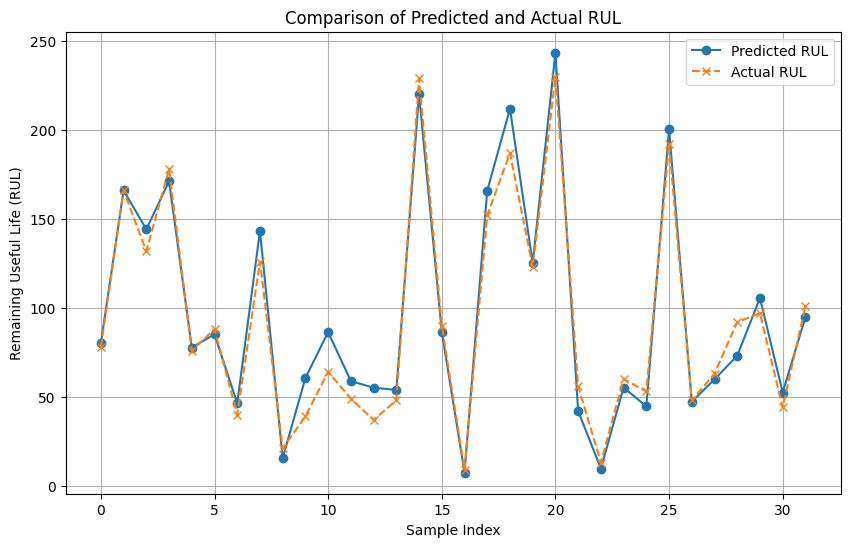

In [70]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


## Huấn luyện mô hình với sequence_length = 10, 50 epochs

In [10]:
# Đưa dataset vào dataloader
dataset = FD001Dataset(df, sequence_length=10)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sau khi tiền xử lý data thì còn 17 cột (do bỏ đi các cột không cần thiết (sensor 1,5,6...))
# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD001Dataset, RUl là đầu ra nên cần bỏ đi, và không được đưa vào mô hình (ban đầu có 17 dim)
input_dim = 14
# Ngoài input_dim=14 ra, thì các tham số các này có thể thay đổi. các tham số còn lại có thể thay đổi tùy thuộc vào mô hình
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.03023559410833878, Val Loss = 0.013345993225342564
Epoch 2: Train Loss = 0.016529507909596026, Val Loss = 0.015530096457129525
Epoch 3: Train Loss = 0.014440438413223334, Val Loss = 0.012355116729234015
Epoch 4: Train Loss = 0.013721347671956095, Val Loss = 0.012346688214869748
Epoch 5: Train Loss = 0.01318236083915902, Val Loss = 0.012303215248750584
Epoch 6: Train Loss = 0.012944233981300492, Val Loss = 0.012505576316823041
Epoch 7: Train Loss = 0.012846017911509886, Val Loss = 0.013728058915735492
Epoch 8: Train Loss = 0.012638886979977159, Val Loss = 0.012149909424835877
Epoch 9: Train Loss = 0.012440813444686774, Val Loss = 0.012373181841065806
Epoch 10: Train Loss = 0.012418400212982858, Val Loss = 0.012509799483532627
Epoch 11: Train Loss = 0.012175340971792577, Val Loss = 0.011985064487934353
Epoch 12: Train Loss = 0.012008521557872293, Val Loss = 0.012089002768569175
Epoch 13: Train Loss = 0.011953972937041509, Val Loss = 0.011923373594219166
Epoch 14: 

In [12]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [13]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


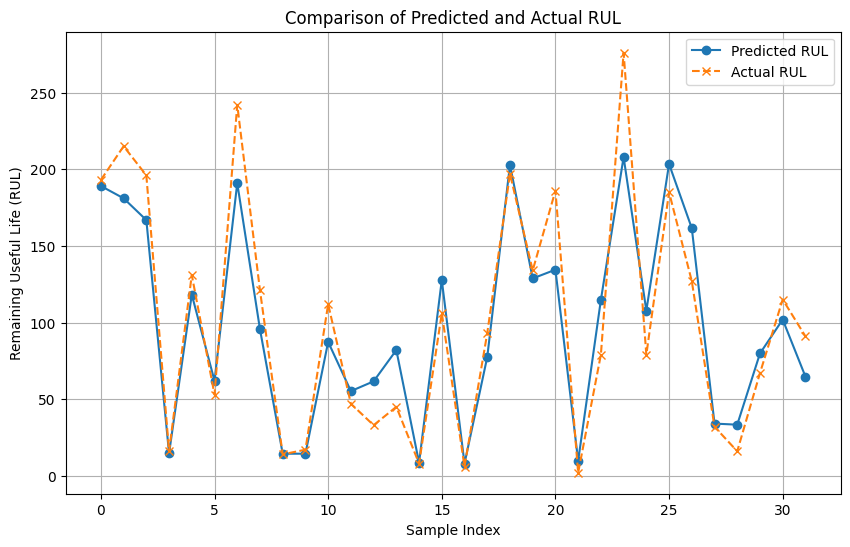

In [14]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


## Huấn luyện mô hình với sequence_length = 30, 50 epochs

In [20]:
# Đưa dataset vào dataloader
dataset = FD001Dataset(df, sequence_length=30)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sau khi tiền xử lý data thì còn 17 cột (do bỏ đi các cột không cần thiết (sensor 1,5,6...))
# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD001Dataset, RUl là đầu ra nên cần bỏ đi, và không được đưa vào mô hình (ban đầu có 17 dim)
input_dim = 14
# Ngoài input_dim=14 ra, thì các tham số các này có thể thay đổi. các tham số còn lại có thể thay đổi tùy thuộc vào mô hình
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.02999364202716262, Val Loss = 0.012059064221207623
Epoch 2: Train Loss = 0.016859618478102256, Val Loss = 0.011673034470830415
Epoch 3: Train Loss = 0.014382737775769521, Val Loss = 0.011981712503207696
Epoch 4: Train Loss = 0.013283532022641183, Val Loss = 0.011274329155918446
Epoch 5: Train Loss = 0.011705067309735527, Val Loss = 0.009756794321006752
Epoch 6: Train Loss = 0.010683578338897746, Val Loss = 0.009186048006118686
Epoch 7: Train Loss = 0.009964981343941175, Val Loss = 0.009484268993407756
Epoch 8: Train Loss = 0.009205762130682365, Val Loss = 0.00886254210595612
Epoch 9: Train Loss = 0.008888264223912245, Val Loss = 0.00846074088182938
Epoch 10: Train Loss = 0.00859042780677293, Val Loss = 0.009414973576460872
Epoch 11: Train Loss = 0.00831703563495581, Val Loss = 0.0076979832149001665
Epoch 12: Train Loss = 0.008035601189607536, Val Loss = 0.007316022469485934
Epoch 13: Train Loss = 0.00803193233871564, Val Loss = 0.010266922817036912
Epoch 14: Tra

In [22]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [23]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


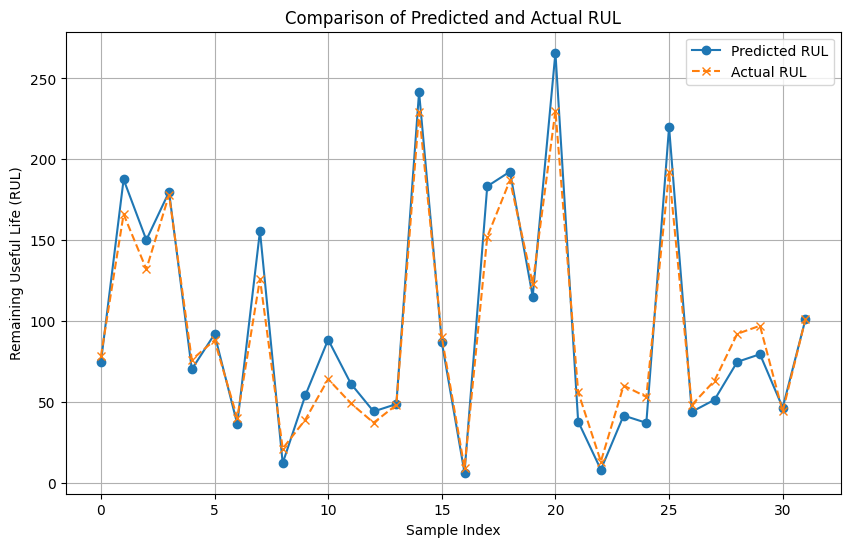

In [24]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


##

In [25]:
# import shap 
# shap.__version__

In [26]:
# samples, targets = next(iter(val_loader))
# print(samples[1].__len__())

In [27]:
# # Define a wrapper to explain the Transformer model
# class TransformerWrapper:
#     def __init__(self, model):
#         self.model = model

#     def __call__(self, inputs):
#         # Convert inputs to tensor if not already
#         if not isinstance(inputs, torch.Tensor):
#             inputs = torch.tensor(inputs, dtype=torch.float32)
#         inputs = inputs.to(device)  # Send to the same device as the model
#         with torch.no_grad():
#             outputs = self.model(inputs)
#         return outputs.cpu().numpy()

In [28]:
# # Instantiate the wrapper
# explainer_model = TransformerWrapper(model)

# sample_data = samples[0]
# sample_data = sample_data.numpy()

# # Ensure sample_data and baseline have correct dimensions
# baseline = np.mean(sample_data, axis=0, keepdims=True)  # Mean across batch
# baseline = baseline[np.newaxis, :, :]  # Add batch dimension to ensure 3D shape: [1, seq_len, feature_dim]
# print(f'baseline shape = {baseline.shape}')

# # SHAP explainer (Kernel SHAP for simplicity)
# explainer = shap.KernelExplainer(explainer_model, baseline)

# # Generate SHAP values
# shap_values = explainer.shap_values(sample_data)
# print(f'shap values = {shap_values.shape}')

In [29]:
# print(f'shap values = {shap_values.shape}')
# shap.summary_plot(shap_values, sample_data)